

```
This goal of this project is to create a model by which twitter posts can be rated as positive or negative or neutral.

I would like to retrain this for the cryptocurrency niche- but need to find a good dataset.... It is working reasonably well using the airline dataset recommended by Sam, with an extra 3k other positive sentiment tweets I found (the original airline dataset was very negative leaning)

*   Neutral = 0
*  Negative = 1
*  Positive = 2


Versions
*  001 - learning pandas and testing dataset
*  002 - testing dataset and adding pie chart
*  003 - settled on airline dataset, basic LTSM test
*  004 - changing to functions and testing other LTSMs
*  005 - adding checks on the LTSM chosen, added ability to check a single tweet
*  006 - added more curated tweets to improve the dataset, adjusted learning rates, added layer, added drops, added epochs, saving best weights

Currently returning val_accuracy of 78.5%, which is what the other people got in my research.






In [0]:
!pip install -U -q PyDrive


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
!curl https://raw.githubusercontent.com/dexterfichuk/GoogleDriveCheckpoint/master/google_drive_checkpoint.py -O

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4522  100  4522    0     0   100k      0 --:--:-- --:--:-- --:--:--  102k


In [0]:
# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
from google_drive_checkpoint import GoogleDriveCheckpoint

Using TensorFlow backend.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os, string, collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import pickle
import time

import datetime

import tensorflow as tf
from tensorflow.contrib import rnn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score


from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model, load_model
from keras.layers.embeddings import Embedding
from keras.layers import Flatten, Dense, Dropout, Convolution1D, MaxPooling1D, SpatialDropout1D, Input, Activation
from keras.layers import GlobalMaxPooling1D, concatenate, LSTM, Bidirectional
from keras.optimizers import Adam, SGD
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

I wanted to build the initial model using a large corpus of pre-defined twitter posts, which have been labeled negative, positive or neutral, but the dataset was incomplete, and I found it innacurate. So I've moved to trying the airline set with approx 15k entries.

In [0]:

!wget https://www.dropbox.com/s/zdlwfpegjgbuxhu/combinedtweetsnew.csv


--2019-03-29 01:31:21--  https://www.dropbox.com/s/zdlwfpegjgbuxhu/combinedtweetsnew.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.1, 2620:100:6021:1::a27d:4101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/zdlwfpegjgbuxhu/combinedtweetsnew.csv [following]
--2019-03-29 01:31:22--  https://www.dropbox.com/s/raw/zdlwfpegjgbuxhu/combinedtweetsnew.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd265b7206d56b7af1dd0dca551.dl.dropboxusercontent.com/cd/0/inline/Ad_F5_Ta5lwn0ulqm53Adbs13iONNliCRhtIFE3zfTLI0z9OTq4busGtQ1u1Mw1B7hXKIqpQIfTtzSgL95d51De1nCzRbx4CYen76Kxh7G6K-aihBz3F_yjwAyV3vA_IaUY/file# [following]
--2019-03-29 01:31:22--  https://ucd265b7206d56b7af1dd0dca551.dl.dropboxusercontent.com/cd/0/inline/Ad_F5_Ta5lwn0ulqm53Adbs13iONNliCRhtIFE3zfTLI0z9OTq4busGtQ1u1Mw1B7hXKIqpQIfTtzSgL95d5

use pandas to clean up the data for processing- in the former set, there were some bad rows, so needed to remove them...also make sure to use the right encoding...  so left in the drop bad lines.




In [0]:
# Read in training data
training_data = pd.read_csv('combinedtweetsnew.csv', error_bad_lines=False)

training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23225 entries, 0 to 23224
Data columns (total 2 columns):
Sentiment    23225 non-null int64
Text         23225 non-null object
dtypes: int64(1), object(1)
memory usage: 363.0+ KB


In [0]:
training_data.describe()

,Sentiment
count,23225.000000
mean,1.104887
std,0.744555
min,0.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,2.000000


In [0]:
type(training_data['Sentiment'][0])

numpy.int64

In [0]:
# Convert the labels to float32 
training_data['Sentiment'] = training_data['Sentiment'].astype('float32')

In [0]:
training_data.isnull().any()

Sentiment    False
Text         False
dtype: bool

In [0]:
# shuffle 
training_data = training_data.sample(frac=1).reset_index(drop=True)


In [0]:
training_data.head()

,Sentiment,Text
0,0.0,Can also but lunch will only b ready at 1 smth...
1,2.0,I favorited a @user video ~http blink-182 - U...
2,1.0,@united CDG-LAS 42 hours. And my luggage is in...
3,0.0,@VirginAmerica hi I just booked a flight but n...
4,1.0,@SouthwestAir been on hold for 1.5 hrs. What's...


In [0]:
def clean_text (text):
    #remove airline hashtag and make lowercase
    text = text.str.lower()
    text = text.replace('\@united', " ", regex=True)
    text = text.replace('\@virginamerica', " ", regex=True)
    text = text.replace('\@usairways', " ", regex=True)
    text = text.replace('\@americanair', " ", regex=True)
    text = text.replace('\@southwestair', " ", regex=True)
    text = text.replace('\@jetblue', " ", regex=True)
    text = text.replace('rt \@user', " ", regex=True)
    #remove urls
    text = text.replace('\~http', '', regex=True)
    text = text.replace('http://[^\s]+[\s]?', '', regex=True)
    text = text.replace('https://[^\s]+[\s]?', '', regex=True)
    #remove hashtags
    text = text.replace('#', " ", regex=True)
    #puntuations
    text = text.replace('i’m','i am', regex=True)
    text = text.replace('\bi m\b','i am', regex=True)
    text = text.replace('n’t','nt', regex=True)
    text = text.replace('t\'s','ts', regex=True)
    text = text.replace('['+string.punctuation+']+', '', regex=True)
    
    #other text cleanup
    text = text.replace('\@', ' ', regex=True)
    text = text.replace('\baa\b','american airlines', regex=True)
    text = text.replace('\bthx\b','thanks', regex=True)
    text = text.replace('\bu\b', 'you', regex=True)
    text = text.replace('\bhrs\b', 'hours', regex=True)
    text = text.replace('\baa\b', 'a', regex=True)
    text = text.replace('\bflightr\b', 'flight', regex=True)
    text = text.replace('\bur\b', 'your', regex=True)
    text = text.replace('\bhr\b', 'hour', regex=True)
    text = text.replace('\bthru\b', 'through', regex=True)
    text = text.replace('\br\b', 'are', regex=True)
    text = text.replace('\bppl\b', 'people', regex=True)
    text = text.replace('\btix\b', 'fix', regex=True)
    text = text.replace('\bplz\b', 'please', regex=True)
    text = text.replace('\bflightd\b', 'flighted', regex=True)
    text = text.replace('\btmrw\b', 'tomorrow', regex=True)
    text = text.replace('\bthx\b', 'thanks', regex=True)
    text = text.replace('\bpls\b', 'please', regex=True)
    text = text.replace('\bfyi\b', 'for your information', regex=True)        
    text = text.replace('\bheyyyy\b', 'hey', regex=True)
    text = text.replace('\bguyyyys\b', 'guys', regex=True)
    text = text.replace('\byall\b', 'you all', regex=True)
    text = text.replace('\basap\b', 'as soon as possible', regex=True)
    text = text.replace('\bbtw\b', 'by the way', regex=True)
    text = text.replace('\bdm\b', 'direct message', regex=True)
    text = text.replace('\bcudtomers\b', 'customers', regex=True)
    text = text.replace('\bhv\b', 'have', regex=True)
    text = text.replace('\bwtf\b', 'what the fuck', regex=True)
    text = text.replace('\biphone\b', 'phone', regex=True)
    text = text.replace('\bmins\b', 'minutes', regex=True)
    text = text.replace('\btv\b', 'television', regex=True)
    text = text.replace('\bokay\b', 'ok', regex=True)
    text = text.replace('\bfeb\b', 'february', regex=True)
    text = text.replace('\byr\b', 'year', regex=True)
    text = text.replace('\bshes\b', 'she is', regex=True)
    text = text.replace('\bnope\b', 'no', regex=True)
    text = text.replace('\bhes\b', 'he is', regex=True)
    text = text.replace('\btill\b', 'until', regex=True)
    text = text.replace('\bomg\b', 'oh my god', regex=True)
    text = text.replace('\btho\b', 'though', regex=True)
    text = text.replace('\bnothappy\b', 'not happy', regex=True)
    text = text.replace('\bthankyou\b', 'thank you', regex=True)
    text = text.replace('\bthnx\b', 'thanks', regex=True)
    text = text.replace('\bmin\b', 'minutes', regex=True)
    text = text.replace('\bmins\b', 'minutes', regex=True)
    text = text.replace('\bwth\b', 'what the hell', regex=True)
    text = text.replace('\bpls\b', 'please', regex=True)

    #crypto specific
    text = text.replace('\bhodl\b', 'hold', regex=True)
    text = text.replace('\bbuidl\b', 'build', regex=True)
    text = text.replace('\s+', ' ', regex=True)
    
    
    return (text)

training_data['Text'] = clean_text(training_data['Text'])

training_data.head()




,Sentiment,Text
0,0.0,can also but lunch will only b ready at 1 smth...
1,2.0,i favorited a user video blink182 up all night
2,1.0,cdglas 42 hours and my luggage is in sfo ive ...
3,0.0,hi i just booked a flight but need to add bag...
4,1.0,been on hold for 15 hrs whats up


Lets see what the ratio of positive and negative sentiment is in the data

In [0]:
training_data.Sentiment.value_counts()

1.0    10095
2.0     7783
0.0     5347
Name: Sentiment, dtype: int64

In [0]:
training_data[training_data.Sentiment == 0].index

Int64Index([    0,     3,     6,    12,    13,    18,    20,    21,    23,
               24,
            ...
            23202, 23203, 23204, 23205, 23207, 23209, 23212, 23214, 23221,
            23224],
           dtype='int64', length=5347)

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt



{1.0: 10095, 2.0: 7783, 0.0: 5347}


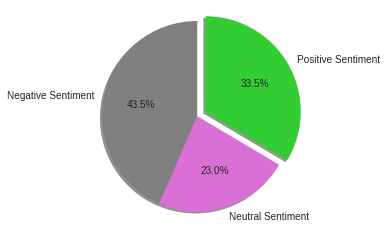

In [0]:
#Data to plot
labels = 'Negative Sentiment', 'Neutral Sentiment', 'Positive Sentiment'
sizes = pd.Series(training_data['Sentiment']).value_counts().to_dict()
print (sizes)
sizes=[sizes[1],sizes[0],sizes[2]]
colors = ['grey', 'orchid', 'limegreen']
 
# Plot
 
explode = (0, 0.0, 0.1)  # only "explode" the 2nd slice 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=colors)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

I think this dataset may be balanced too much to negative sentiment... however, if I remove, it will be too small...

Dataset is now ready to be put into a model...
I'm going to use a RNN (LSTM), since the text sentiment can be tought of as a times series, and will need previous words in a sentence, passing hidden states.


Tokenization -  some of this code taken from https://medium.com/@martinpella/customers-tweets-classification-41cdca4e2de
and a bunch from https://colab.research.google.com/drive/1QMMWAr1J5oa-1T3Y5pyAdDwlfArGMeUT

In [0]:
import re

In [0]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): 
    return re_tok.sub(' \1 ', s).split()


training_data['tokenized'] = training_data['Text'].apply(lambda row: tokenize(row))

In [0]:
training_data[['Text', 'tokenized']].head()

,Text,tokenized
0,can also but lunch will only b ready at 1 smth...,"[can, also, but, lunch, will, only, b, ready, ..."
1,i favorited a user video blink182 up all night,"[i, favorited, a, user, video, blink182, up, a..."
2,cdglas 42 hours and my luggage is in sfo ive ...,"[cdglas, 42, hours, and, my, luggage, is, in, ..."
3,hi i just booked a flight but need to add bag...,"[hi, i, just, booked, a, flight, but, need, to..."
4,been on hold for 15 hrs whats up,"[been, on, hold, for, 15, hrs, whats, up]"


Vocabulary Collection

In [0]:
def update_vocab_counter(row):
    for word in row:
        vocab_counter[word] += 1

In [0]:
vocab_counter = collections.Counter()
training_data['tokenized'].apply(update_vocab_counter);
vocab = sorted(vocab_counter, key=vocab_counter.get, reverse=True)

In [0]:
len(vocab)

23729

Limit to the most common 5000 words


In [0]:
max_words = 5000


Dictionary that map each token with their id

In [0]:
w2id = {w:i for i, w in enumerate(vocab[:max_words])}

Replace each token out of top 5000 with 'unk'

In [0]:
w2id['unk'] = 0

Transform each token by their id

In [0]:
def transform_to_ids(row):
    return [w2id[w] if w in w2id else w2id['unk'] for w in row]

In [0]:
training_data['tokenized_int'] = training_data['tokenized'].apply(lambda x: transform_to_ids(x))

Tweets length

In [0]:
lens = training_data['tokenized_int'].apply(lambda x: len(x))

In [0]:
min(lens), max(lens), np.mean(lens)

(1, 65, 15.811065662002154)

Limit the legnth to 40 words




In [0]:
maxlen = 40

Split the data up into training and testing

In [0]:
X_train,X_test,y_train,y_test = train_test_split(training_data['tokenized_int'], 
                                                 training_data['Sentiment'], test_size=0.1, shuffle=False, 
                                                 random_state=42)

In [0]:
x_train = sequence.pad_sequences(X_train, maxlen=maxlen, value=0)
x_test = sequence.pad_sequences(X_test, maxlen=maxlen, value=0)

In [0]:
print (x_train)


[[   0    0    0 ...   46   22 1776]
 [   0    0    0 ...   42   43  196]
 [   0    0    0 ...   75    4    0]
 ...
 [   0    0    0 ...    8  561    0]
 [   0    0    0 ...  986  561 1077]
 [   0    0    0 ...  230   13    7]]


One hot encode

In [0]:
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)



In [0]:
print(y_train.shape)
print(y_test)

(20902, 3)
[[0. 0. 1.]
 [0. 1. 0.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]]


LSTM

LTSM code from here: https://github.com/keras-team/keras/blob/master/examples/imdb_bidirectional_lstm.py

In [0]:
max_features = 5000
batch_size = 500
epochs = 100



model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64, dropout=0.50, recurrent_dropout=0.50)))
model.add(Dropout(0.50))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.50))
model.add(Dense(3, activation='softmax'))

print (model.summary())



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           640000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)      

I've tried a number of different optimizers, SGD, Adagrad, adam and RMSprop
Best result is 78% accuracy, which is in line with what others have gotten.

In [0]:
checkpoint = GoogleDriveCheckpoint('6new_weights_{epoch:02d}_{val_acc:.2f}.hdf5', drive,  verbose=1, save_best_only=True, mode='auto')
# drive directory link : https://drive.google.com/open?id=1vtt19oHvcOetL1QHwUwCzE2HnH8cdRrv

# try using different optimizers and different optimizer configs
from keras import optimizers

opt = SGD(lr=0.5)
model.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])
#model.compile('RMSprop', 'categorical_crossentropy', metrics=['accuracy'])


In [0]:

print('Train...')
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=[x_test, y_test],
          callbacks=[checkpoint])
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Train...
Instructions for updating:
Use tf.cast instead.
Train on 20902 samples, validate on 2323 samples
Epoch 1/100
20902/20902 [==============================] - 11s 544us/step - loss: 1.0685 - acc: 0.4314 - val_loss: 1.0478 - val_acc: 0.4593

Epoch 00001: val_loss improved from inf to 1.04778, saving model to 6new_weights_01_0.46.hdf5
Uploaded file 6new_weights_01_0.46.hdf5 to drive with ID 15HCQnDqJrRs_oFyb8wyt9hhCDdN7VafO
Epoch 2/100
20902/20902 [==============================] - 9s 437us/step - loss: 1.0435 - acc: 0.4672 - val_loss: 0.9982 - val_acc: 0.5347

Epoch 00002: val_loss improved from 1.04778 to 0.99819, saving model to 6new_weights_02_0.53.hdf5
Uploaded file 6new_weights_02_0.53.hdf5 to drive with ID 15aNzrdaJ9fUXeIUGTMEKmZQSdX2SU7qU
Epoch 3/100
20902/20902 [==============================] - 9s 437us/step - loss: 1.0215 - acc: 0.4978 - val_loss: 0.9731 - val_acc: 0.5514

Epoch 00003: val_loss improved from 0.99819 to 0.97314, saving model to 6new_weights_03_0.55.hdf5
U

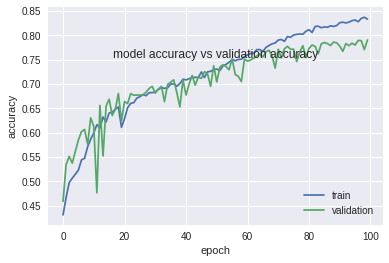

In [0]:
from matplotlib import*
# plot learning curves
pyplot.plot(history.history['acc'], label='train')
pyplot.plot(history.history['val_acc'], label='test')
pyplot.title('model accuracy vs validation accuracy', pad=-50)
pyplot.ylabel('accuracy')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

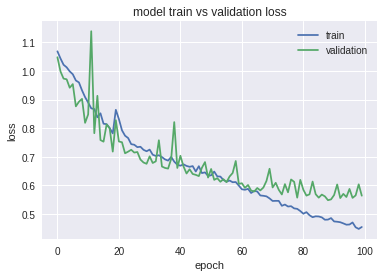

In [0]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

Test a tweet

In [0]:
# Load the best weights (epoch 89)
#!wget https://www.dropbox.com/s/qxd2vdnkk3cgiz1/new_weights_89_0.79.hdf5
#model.load_weights('new_weights_89_0.79.hdf5')
#opt = SGD(lr=0.5)
#model.compile(opt, 'categorical_crossentropy', metrics=['accuracy'])

In [0]:
# serialize model to JSON
#model_json = model.to_json()
#with open("model.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
#model.save_weights("model.h5")
#print("Saved model to disk")

Saved model to disk


In [0]:
twt = 'the class on machine learning was very rewarding. with good content and instructors. tried an interesting project that pushed me forward. still have much to learn.'
#twt = 'it may be the years best seller'
#twt = 'he really makes my skin crawl, yuck!'
#twt = 'bitcoin is crashing!'

# putting it into a dataframe so i can use the existing functions
data = [['8', twt]] 
#using a 8 as a sentiment placeholder for the dataframe
  
# Create the pandas DataFrame 
tdf = pd.DataFrame(data, columns = ['Sentiment', 'Text']) 
  
# print dataframe. 
tdf 

,Sentiment,Text
0,8,the class on machine learning was very rewardi...


In [0]:
#clean the tweet 
tdf['Text'] = clean_text(tdf['Text'])

#tokenize the tweet
tdf['tokenized']= tdf['Text'].apply(lambda row: tokenize(row))

tdf['tokenized_int'] = tdf['tokenized'].apply(lambda x: transform_to_ids(x))

#padding the tweet to have exactly the same shape
tdf_test = sequence.pad_sequences(tdf['tokenized_int'], maxlen=maxlen, value=0)

sentiment = model.predict(tdf_test,batch_size=1,verbose = 2)[0]
print('Tweet:', twt)
if(np.argmax(sentiment) == 0):
    print("Sentiment: neutral")
elif (np.argmax(sentiment) == 1):
    print("Sentiment: negative")
elif (np.argmax(sentiment) == 2):
    print("Sentiment: positive")

Tweet: the class on machine learning was very rewarding. with good content and instructors. tried an interesting project that pushed me forward. still have much to learn.
Sentiment: positive
